In [2]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os

In [3]:
################################'Generate regressor X from an AR(1)'##############################
################################ Xt = α + βXt-1 + εt

T=1000;  # sample size
df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y' ])
alpha = 1;    # intercept parameter
beta = 0.9;   # autoregressive parameter
sigma = 3;  # standard error of innovations
x1 = alpha/(1-beta) # define initial value for time series x
mu=1.7

epsilon = sigma*np.random.randn(T) + mu; # generate a vector of T random normal
df.iloc[0,:] = [x1] # initialize x

for i in range(0, T-1):
    df.iloc[i+1,0] = alpha + beta * df.iloc[i,0] + epsilon[i+1] # generate X(t) recursively
    # Xt = α + βXt-1 + εt


In [4]:
################################ Generate Y ##############################
################################ # Yt = α + βYt-1 + γXt + εt + θεt-1

T_2=1000
alpha_y = 6
beta_y = 0.3
gamma = 0.9
theta = 0.9
sigma = 8
epsilon_y = sigma*np.random.randn(T_2,1)
df['epsilon_y'] = epsilon_y
y1 = 0
df['y'] = 0

for j in range(0, T-1):
    df.iloc[j+1,1] = alpha_y + beta_y * df.iloc[j,1] + gamma * df.iloc[j+1,0] + epsilon_y[j] + theta * epsilon_y[j-1]
    # Yt = α + βYt-1 + γXt + εt + θεt-1

print(df)


             x          y  epsilon_y
0         10.0   0.000000 -10.579906
1     9.142385  -5.039161  -3.602353
2    20.370357   9.697305  -8.681275
3    19.664916  14.684223   1.684162
4    24.144171  26.006035  -7.301688
..         ...        ...        ...
995  31.605562  71.518284   8.032915
996  28.780079  67.129584  -1.776416
997  32.243936  60.611625  -2.957412
998  29.500845  46.178061   6.382064
999  24.428661  45.559607  -9.652668

[1000 rows x 3 columns]


In [5]:
import statsmodels.formula.api as smf

# Fit quantile regression at the 0.5 quantile
y = df['y'].values.astype(float)
x = df['x'].values.astype(float)
epsilon_y = df['epsilon_y'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
epsilon_lag = np.roll(epsilon_y, 1)
epsilon_lag[0] = 0

quant_reg_1 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.1)
quant_reg_5 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.5)
quant_reg_9 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.9)

#quant_reg_1 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.1)
#quant_reg_5 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x ).fit(q=0.5)
#quant_reg_9 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x + epsilon_y + theta * epsilon_lag).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary())


                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.2684
Model:                       QuantReg   Bandwidth:                       4.726
Method:                 Least Squares   Sparsity:                        60.12
Date:                Fri, 21 Apr 2023   No. Observations:                 1000
Time:                        11:12:42   Df Residuals:                      999
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6798      0.011     59.711      0.000       0.657       0.702
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3356
Model:                       QuantReg   Bandwidth:  

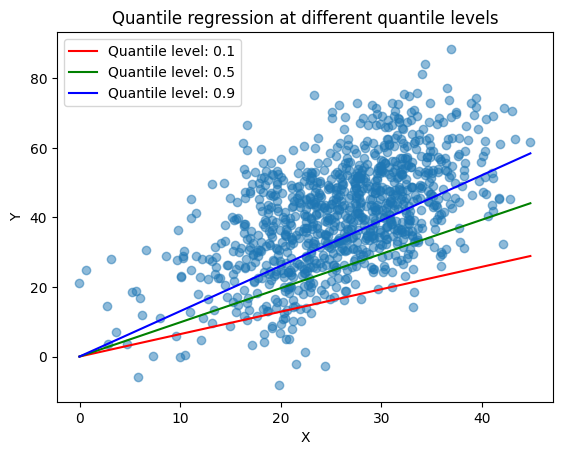

In [51]:
################################ Quantile regression plot ##############################
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
# Create a scatter plot of the data
plt.scatter(x, y, alpha=0.5)

# Plot the quantile regression lines at different quantile levels
x_sort = np.sort(x)
y_pred_1 = quant_reg_1.predict(x_sort)
y_pred_5 = quant_reg_5.predict(x_sort)
y_pred_9 = quant_reg_9.predict(x_sort)

plt.plot(x_sort, y_pred_1, color='red', label='Quantile level: 0.1')
plt.plot(x_sort, y_pred_5, color='green', label='Quantile level: 0.5')
plt.plot(x_sort, y_pred_9, color='blue', label='Quantile level: 0.9')

# Add a legend and labels to the plot
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quantile regression at different quantile levels')
plt.show()



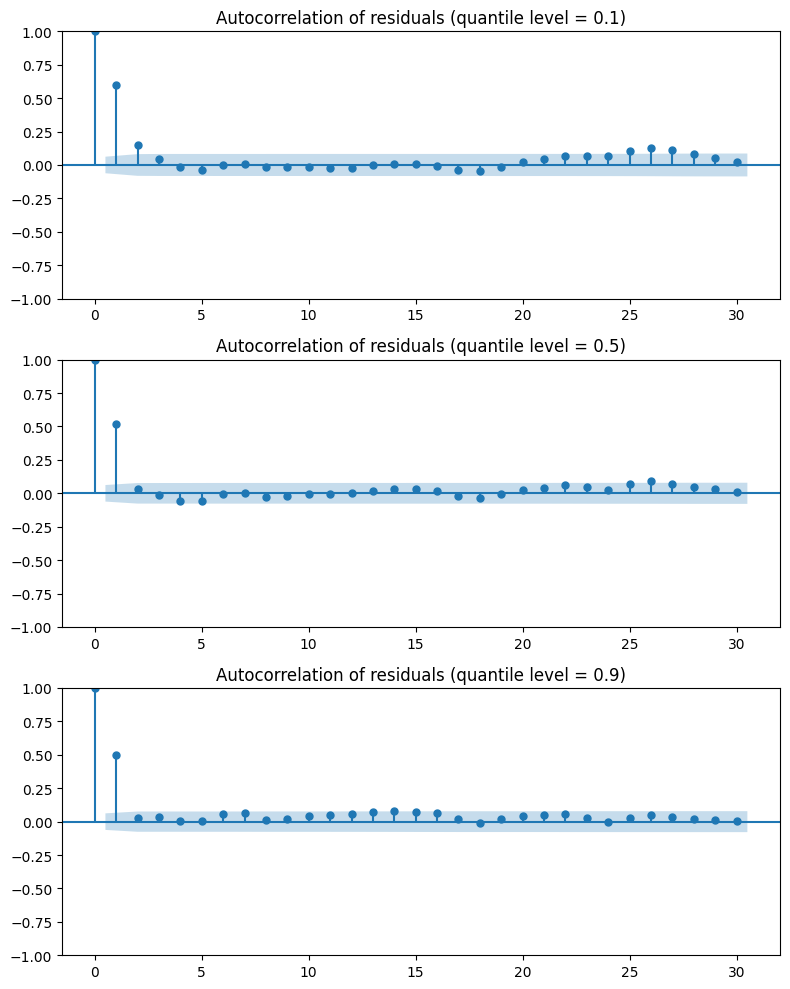

In [6]:
################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

#Autocorrelation fades away as the lags increase



In [53]:
################################ OLS estimation of the parameters ##############################
# Add lagged values of Y and epsilon
y_lag = np.roll(y, 1)
y_lag[0] = 0
epsilon_lag = np.roll(epsilon_y, 1)
epsilon_lag[0] = 0

# Construct the design matrix
X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))

#This line creates a new numpy array called X that is the design matrix for regression. 
# It is created by stacking columns of np.ones_like(x) (a vector of ones with the same shape as x), 
# y_lag, x, and epsilon_lag horizontally using np.column_stack(). 
# The first column of X is a vector of ones to represent the intercept term.

# Estimate the parameters
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Print the parameter estimates
print("alpha_hat = {:.4f}".format(beta_hat[0]))
print("beta_hat = {:.4f}".format(beta_hat[1]))
print("gamma_hat = {:.4f}".format(beta_hat[2]))
print("theta_hat = {:.4f}".format(beta_hat[3]))

alpha_hat = 1.9059
beta_hat = 0.6216
gamma_hat = 0.5370
theta_hat = 0.9910


In [54]:
################################ GLS estimation of the parameters ##############################
resid = y - X @ beta_hat# Compute the residuals

acf_resid, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05) # Compute the ACF of the residuals

# Estimate the covariance parameters
sigma2 = np.var(resid) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)

# Compute the GLS estimator of the coefficients
beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y

# Print the parameter estimates
print("alpha_hat = {:.4f}".format(beta_gls[0]))
print("beta_hat = {:.4f}".format(beta_gls[1]))
print("gamma_hat = {:.4f}".format(beta_gls[2]))
print("theta_hat = {:.4f}".format(beta_gls[3]))

alpha_hat = 2.4027
beta_hat = 0.6084
gamma_hat = 0.5409
theta_hat = 1.1107


In [ ]:
#GLS
alpha_hat = 2.4027
beta_hat = 0.6084
gamma_hat = 0.5409
theta_hat = 1.1107

#True values
alpha_y = 6
beta_y = 0.3
gamma = 0.9
theta = 0.9
sigma = 8

(array([0.56980667, 0.51553936, 0.42057159, 0.40361305, 0.30864528,
        0.17976044, 0.18654385, 0.15601849, 0.09835948, 0.09835948,
        0.07461754, 0.06105071, 0.04748389, 0.04409218, 0.02713365,
        0.03391706, 0.03391706, 0.02035024, 0.01695853, 0.02374194,
        0.02374194, 0.00678341, 0.00678341, 0.00339171, 0.00678341,
        0.        , 0.        , 0.00339171, 0.01017512, 0.        ,
        0.        , 0.00678341, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00339171]),
 array([4.03737489e-04, 2.95240583e-01, 5.90077429e-01, 8.84914275e-01,
        1.17975112e+00, 1.47458797e+00, 1.76942481e+00, 2.06426166e+00,
        2.35909851e+00, 2.65393535e+00, 2.94877220e+00, 3.24360904e+00,
        3.53844589e+00, 3.83328274e+00, 4.12811958e+00, 4.42295643e+00,
        4.71779327e+00, 5.0126

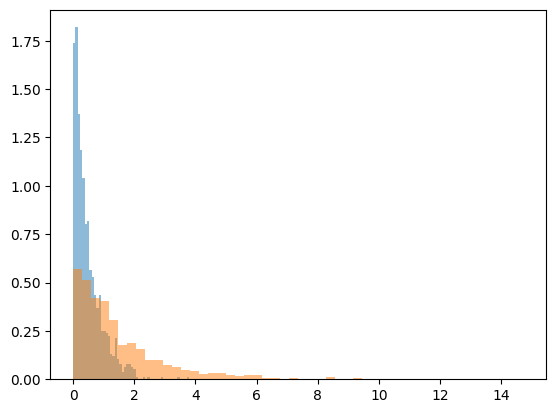

In [29]:
################################ Laplace normal ##############################
T=1000
z = np.random.exponential(0.5, T)
z2 = np.random.exponential(1.5, T)
plt.hist(z, bins=50, density=True, alpha=0.5)
plt.hist(z2, bins=50, density=True, alpha=0.5)

(array([0.007799  , 0.        , 0.        , 0.01559801, 0.03119602,
        0.02339701, 0.        , 0.05459303, 0.04679402, 0.05459303,
        0.10918606, 0.13258307, 0.12478406, 0.17937709, 0.21057311,
        0.28856315, 0.2027741 , 0.32755817, 0.34315618, 0.36655319,
        0.41334721, 0.42114622, 0.44454323, 0.42894522, 0.42114622,
        0.35095518, 0.33535717, 0.3821512 , 0.31975916, 0.27296514,
        0.37435219, 0.13258307, 0.2027741 , 0.16377908, 0.12478406,
        0.13258307, 0.10138705, 0.07799004, 0.03119602, 0.02339701,
        0.02339701, 0.04679402, 0.02339701, 0.        , 0.01559801,
        0.007799  , 0.        , 0.        , 0.        , 0.007799  ]),
 array([-3.0347003 , -2.9064788 , -2.77825729, -2.65003579, -2.52181429,
        -2.39359279, -2.26537129, -2.13714979, -2.00892829, -1.88070679,
        -1.75248529, -1.62426379, -1.49604229, -1.36782078, -1.23959928,
        -1.11137778, -0.98315628, -0.85493478, -0.72671328, -0.59849178,
        -0.47027028, -0.34

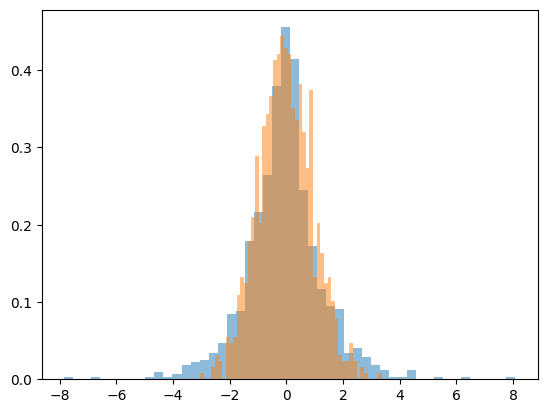

In [35]:
T=1000
z = np.random.laplace(0, 1, T)
z2 = np.random.laplace(0, 1, T)
z3 = np.random.normal(0, 1, T)
plt.hist(z, bins=50, density=True, alpha=0.5)
#plt.hist(z2, bins=50, density=True, alpha=0.5)
plt.hist(z3, bins=50, density=True, alpha=0.5)

In [67]:
################################ OLS estimation of the parameters ##############################
# Add lagged values of Y and epsilon
y_lag_2 = np.roll(y, 1)
y_lag_2[0] = 0

eps = np.random.laplace(0, 1, T)
eps_lag = np.roll(eps, 1)
eps_lag[0] = 0

# Construct the design matrix
X = np.column_stack((np.ones_like(x), y_lag, x, eps))

#This line creates a new numpy array called X that is the design matrix for regression. 
# It is created by stacking columns of np.ones_like(x) (a vector of ones with the same shape as x), 
# y_lag, x, and epsilon_lag horizontally using np.column_stack(). 
# The first column of X is a vector of ones to represent the intercept term.

# Estimate the parameters
beta_hat_2 = np.linalg.inv(X.T @ X) @ X.T @ y

# Print the parameter estimates
print("alpha_hat = {:.4f}".format(beta_hat_2[0]))
print("beta_hat = {:.4f}".format(beta_hat_2[1]))
print("gamma_hat = {:.4f}".format(beta_hat_2[2]))
print("theta_hat = {:.4f}".format(beta_hat_2[3]))


################################ GLS estimation of the parameters ##############################
resid_2 = y - X @ beta_hat_2# Compute the residuals

acf_resid_2, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05) # Compute the ACF of the residuals

# Estimate the covariance parameters
sigma2_2 = np.var(resid_2) * (1 - acf_resid_2[1])
sigma2_array_2 = np.full(T, sigma2_2)
rho_2 = acf_resid_2[1] / (1 - acf_resid_2[1])
S_2 = np.diag(sigma2_array_2) + rho_2 * np.diag(np.sqrt(sigma2_array_2[:-1] * sigma2_array_2[1:]), k=1) + rho_2 * np.diag(np.sqrt(sigma2_array_2[:-1] * sigma2_array_2[1:]), k=-1)

# Compute the GLS estimator of the coefficients
beta_gls_2 = np.linalg.inv(X.T @ np.linalg.inv(S_2) @ X) @ X.T @ np.linalg.inv(S_2) @ y

# Print the parameter estimates
print("alpha_hat_GLS2 = {:.4f}".format(beta_gls_2[0]))
print("beta_hat_GLS2 = {:.4f}".format(beta_gls_2[1]))
print("gamma_hat_GLS2 = {:.4f}".format(beta_gls_2[2]))
print("theta_hat_GLS2 = {:.4f}".format(beta_gls_2[3]))

alpha_hat = 2.3788
beta_hat = 0.6156
gamma_hat = 0.5101
theta_hat = -0.0542
alpha_hat_GLS2 = 1.6911
beta_hat_GLS2 = 0.7086
gamma_hat_GLS2 = 0.3915
theta_hat_GLS2 = -0.0501


In [ ]:
#GLS
alpha_hat = 2.4027
beta_hat = 0.6084
gamma_hat = 0.5409
theta_hat = 1.1107

#True values
alpha_y = 6
beta_y = 0.3
gamma = 0.9
theta = 0.9
sigma = 8

#Laplace OLS
alpha_hat = 2.3253
beta_hat = 0.6166
gamma_hat = 0.5115
theta_hat = -0.2555
#Laplace GLS
alpha_hat_GLS2 = 1.6428
beta_hat_GLS2 = 0.7094
gamma_hat_GLS2 = 0.3930
theta_hat_GLS2 = -0.2704